In [1]:
import pandas as pd
import requests
import time
from io import StringIO
import concurrent.futures
import numpy as np

# --- CONFIGURACIÓN ---
url_base = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports"

mapeo_columnas = {
    'Province/State': 'Province_State', 
    'Country/Region': 'Country_Region',
    'Last Update': 'Last_Update', 
    'Lat': 'Lat', 
    'Long_': 'Long_',
    'Confirmed': 'Confirmed', 
    'Deaths': 'Deaths', 
    'Recovered': 'Recovered',
    'Active': 'Active', 
    'Combined_Key': 'Combined_Key',
    'Incident_Rate': 'Incident_Rate', 
    'Incidence_Rate': 'Incident_Rate',
    'Case_Fatality_Ratio': 'Case_Fatality_Ratio', 
    'Case-Fatality_Ratio': 'Case_Fatality_Ratio'
}

columnas_finales = list(set(mapeo_columnas.values()))

def procesar_reporte_diario(argumentos):
    fecha, url = argumentos
    
    try:
        respuesta = requests.get(url, timeout=15)
        if respuesta.status_code != 200:
            return None, f"Status {respuesta.status_code}"

        try:
            datos_csv = StringIO(respuesta.text)
            df_dia = pd.read_csv(datos_csv, on_bad_lines='skip')
        except:
            try:
                datos_csv = StringIO(respuesta.content.decode('latin-1'))
                df_dia = pd.read_csv(datos_csv, on_bad_lines='skip')
            except Exception as e:
                return None, f"Error lectura: {e}"

        # 1. Normalizar columnas
        df_dia.rename(columns=mapeo_columnas, inplace=True)
        
        # 2. Quedarse sólo con columnas necesarias
        columnas_presentes = [c for c in columnas_finales if c in df_dia.columns]
        df_dia = df_dia[columnas_presentes]

        # 3. Llenar NaN para poder filtrar
        for col in ['Confirmed', 'Deaths']:
            if col in df_dia.columns:
                df_dia[col] = df_dia[col].fillna(0)
            else:
                df_dia[col] = 0  

        # 4. Filtrar filas útiles
        filas_validas = (df_dia['Confirmed'] > 0) | (df_dia['Deaths'] > 0)
        df_dia = df_dia[filas_validas]

        # 5. Filtrar filas sin país
        if 'Country_Region' in df_dia.columns:
            df_dia = df_dia.dropna(subset=['Country_Region'])

        # 6. Optimización de tipos
        for col in ['Confirmed', 'Deaths', 'Recovered', 'Active']:
            if col in df_dia.columns:
                df_dia[col] = pd.to_numeric(df_dia[col], downcast='integer')
        
        for col in ['Lat', 'Long_', 'Incident_Rate', 'Case_Fatality_Ratio']:
            if col in df_dia.columns:
                df_dia[col] = pd.to_numeric(df_dia[col], downcast='float')

        df_dia['fecha_archivo'] = fecha
        
        if df_dia.empty:
            return None, "Vacío tras filtro"

        return df_dia, None 

    except Exception as e:
        return None, f"Error de conexión: {e}"

def generar_urls_reportes(anio_inicio, anio_fin):
    urls_a_procesar = []
    rango_fechas = pd.date_range(start=f'{anio_inicio}-01-01', end=f'{anio_fin}-12-31')
    
    for fecha in rango_fechas:
        formato = fecha.strftime('%m-%d-%Y')
        url = f"{url_base}/{formato}.csv"
        urls_a_procesar.append((fecha, url))
    
    return urls_a_procesar

# --- EJECUCIÓN ---
if __name__ == '__main__':
    tiempo_inicio = time.time()
    
    tareas_descarga = generar_urls_reportes(2021, 2022)

    dataframes_descargados = []
    
    # Descarga en paralelo
    with concurrent.futures.ThreadPoolExecutor(max_workers=20) as ejecutor:
        resultados_descarga = ejecutor.map(procesar_reporte_diario, tareas_descarga)
        
        for (fecha, url), (df_dia, error) in zip(tareas_descarga, resultados_descarga):
            if df_dia is not None:
                dataframes_descargados.append(df_dia)


    if dataframes_descargados:
        datos_covid_anuales = pd.concat(dataframes_descargados, ignore_index=True)
        
        # Limpieza final por si quedan NaN
        columnas_enteras = ['Confirmed', 'Deaths', 'Recovered', 'Active']
        for col in columnas_enteras:
            if col in datos_covid_anuales.columns:
                datos_covid_anuales[col] = datos_covid_anuales[col].fillna(0).astype('int32')

        print("-" * 40)
        print(f"TOTAL FILAS: {datos_covid_anuales.shape}")
        print(datos_covid_anuales.info())
        print("-" * 40)
    
    tiempo_total = time.time() - tiempo_inicio
    print(f"Tiempo total: {tiempo_total:.2f} segundos")


----------------------------------------
TOTAL FILAS: (2902197, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2902197 entries, 0 to 2902196
Data columns (total 13 columns):
 #   Column               Dtype         
---  ------               -----         
 0   Incident_Rate        float64       
 1   Province_State       object        
 2   Deaths               int32         
 3   Case_Fatality_Ratio  float32       
 4   Country_Region       object        
 5   Confirmed            int32         
 6   Active               int32         
 7   Recovered            int32         
 8   Long_                float32       
 9   Lat                  float32       
 10  Combined_Key         object        
 11  Last_Update          object        
 12  fecha_archivo        datetime64[ns]
dtypes: datetime64[ns](1), float32(3), float64(1), int32(4), object(4)
memory usage: 210.3+ MB
None
----------------------------------------
Tiempo total: 22.23 segundos


In [12]:
covid_anuales.shape

(2902197, 14)

In [4]:
#PARTE 3
#CARGAR DATOS
import pandas as pd
import time
covid_anuales = pd.DataFrame()
inicio_time = time.time()
for anio in range(2021,2023):
  for j in range(1,13):
    mes = f"{j:02d}"
    for i in range(1,32):
      dia = f"{i:02d}"
      download_url = f"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/refs/heads/master/csse_covid_19_data/csse_covid_19_daily_reports/{mes}-{dia}-{anio}.csv"
      try:
        aux = pd.read_csv(download_url)
        covid_anuales = pd.concat([covid_anuales,aux],ignore_index=True)
        #print(f'{dia}-{mes}-{anio} Descargado Correctamente')
      except Exception as e:
        pass
        print(f"El mes {mes} no tiene {dia} dias en el año {anio}")
fin_time = time.time()
print("-" * 40)
print(f"TOTAL FILAS: {covid_anuales.shape}")
print(covid_anuales.info())
print("-" * 40)
print(f'Tiempo de descarga: {fin_time - inicio_time} segundos')

El mes 02 no tiene 29 dias en el año 2021
El mes 02 no tiene 30 dias en el año 2021
El mes 02 no tiene 31 dias en el año 2021
El mes 04 no tiene 31 dias en el año 2021
El mes 06 no tiene 31 dias en el año 2021
El mes 09 no tiene 31 dias en el año 2021
El mes 11 no tiene 31 dias en el año 2021
El mes 02 no tiene 29 dias en el año 2022
El mes 02 no tiene 30 dias en el año 2022
El mes 02 no tiene 31 dias en el año 2022
El mes 04 no tiene 31 dias en el año 2022
El mes 06 no tiene 31 dias en el año 2022
El mes 09 no tiene 31 dias en el año 2022
El mes 11 no tiene 31 dias en el año 2022
----------------------------------------
TOTAL FILAS: (2931108, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2931108 entries, 0 to 2931107
Data columns (total 14 columns):
 #   Column               Dtype  
---  ------               -----  
 0   FIPS                 float64
 1   Admin2               object 
 2   Province_State       object 
 3   Country_Region       object 
 4   Last_Update          o

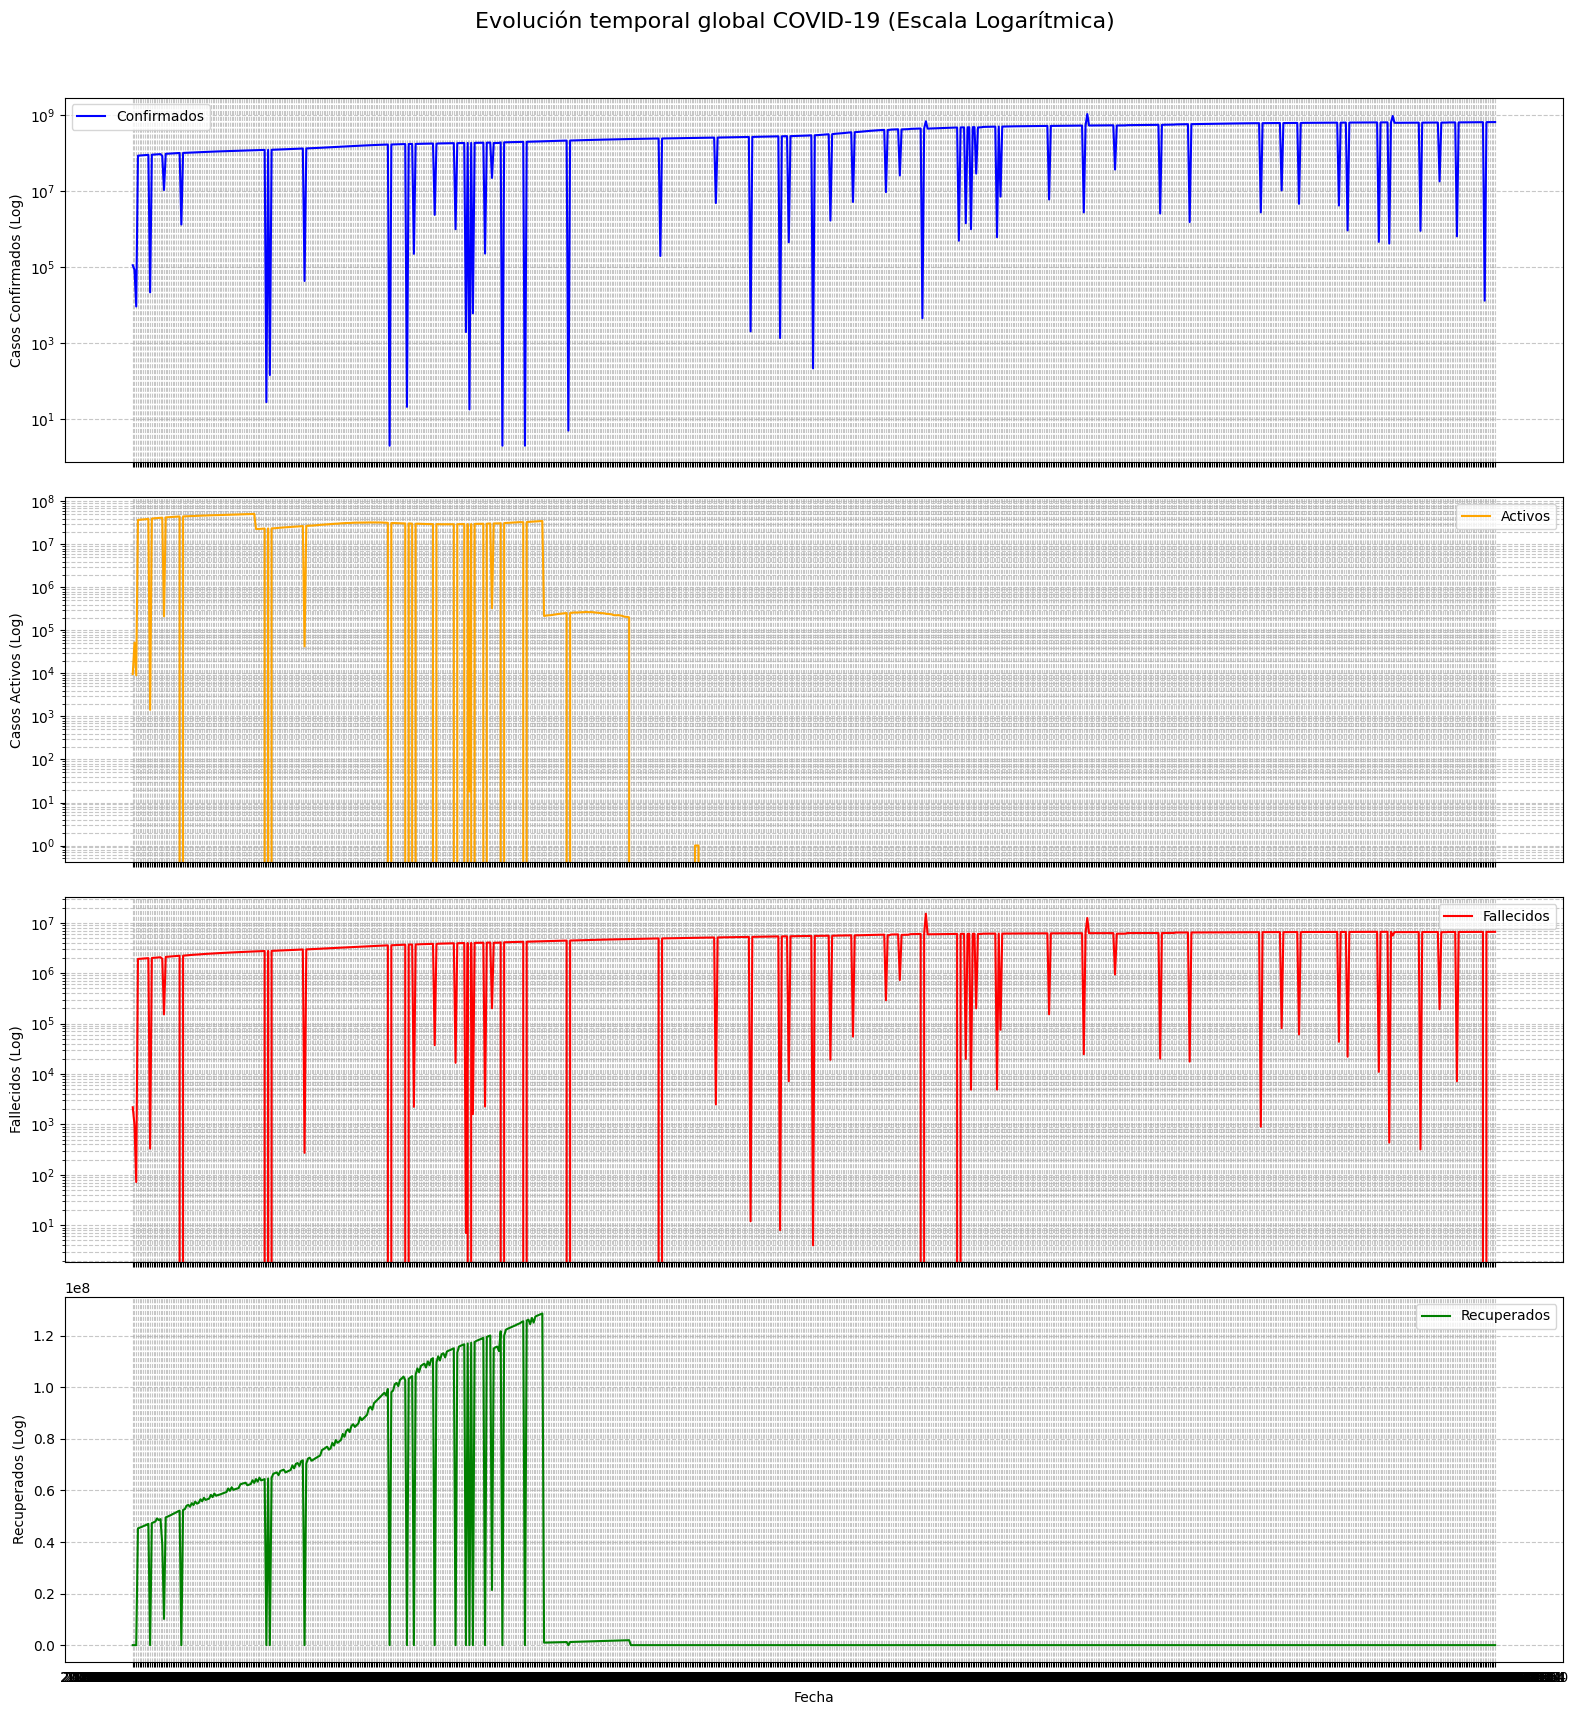

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import glob


global_daily = datos_covid_anuales.groupby("Last_Update")[["Confirmed", "Deaths", "Recovered", "Active"]].sum()

fig, axes = plt.subplots(4, 1, figsize=(16, 18), sharex=True)
fig.suptitle("Evolución temporal global COVID-19 (Escala Logarítmica)", fontsize=16)

axes[0].plot(global_daily.index, global_daily["Confirmed"], label="Confirmados", color='blue')
axes[0].set_ylabel("Casos Confirmados (Log)")
axes[0].set_yscale("log")
axes[0].legend()
axes[0].grid(True, which="both", linestyle="--", alpha=0.7)

axes[1].plot(global_daily.index, global_daily["Active"], label="Activos", color='orange')
axes[1].set_ylabel("Casos Activos (Log)")
axes[1].set_yscale("log")
axes[1].legend()
axes[1].grid(True, which="both", linestyle="--", alpha=0.7)

axes[2].plot(global_daily.index, global_daily["Deaths"], label="Fallecidos", color='red')
axes[2].set_ylabel("Fallecidos (Log)")
axes[2].set_yscale("log")
axes[2].legend()
axes[2].grid(True, which="both", linestyle="--", alpha=0.7)

axes[3].plot(global_daily.index, global_daily["Recovered"], label="Recuperados", color='green')
axes[3].set_ylabel("Recuperados (Log)")
axes[3].set_xlabel("Fecha")
axes[3].legend()
axes[3].grid(True, which="both", linestyle="--", alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

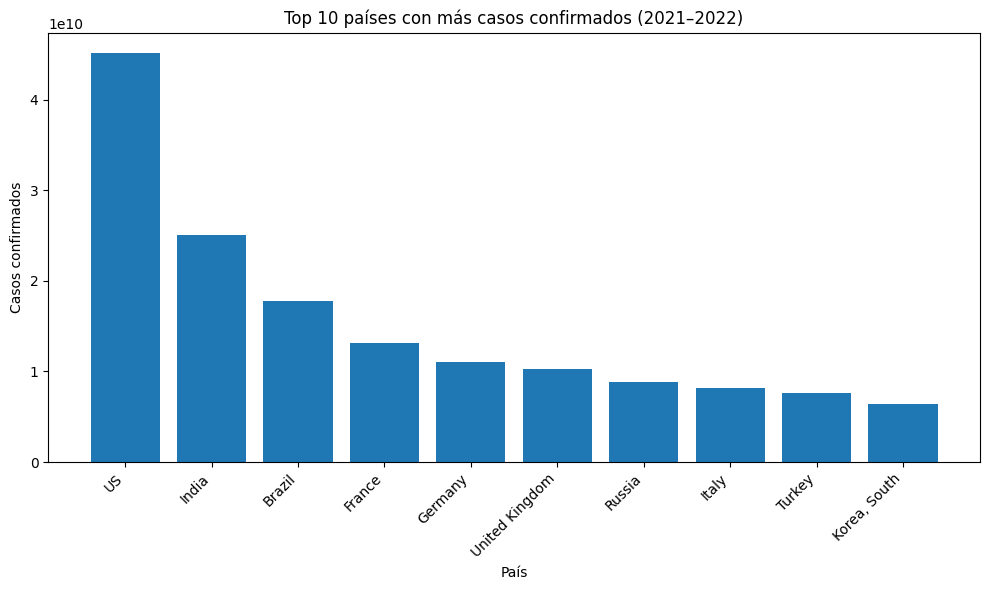

In [ ]:
#2. Comparativa Top 10 países con más casos confirmados (barras).
top10 = datos_covid_anuales.groupby("Country_Region")["Confirmed"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.bar(top10.index, top10.values)
plt.xticks(rotation=45, ha="right")

plt.title("Top 10 países con más casos confirmados (2021–2022)")
plt.xlabel("País")
plt.ylabel("Casos confirmados")
plt.tight_layout()
plt.show()

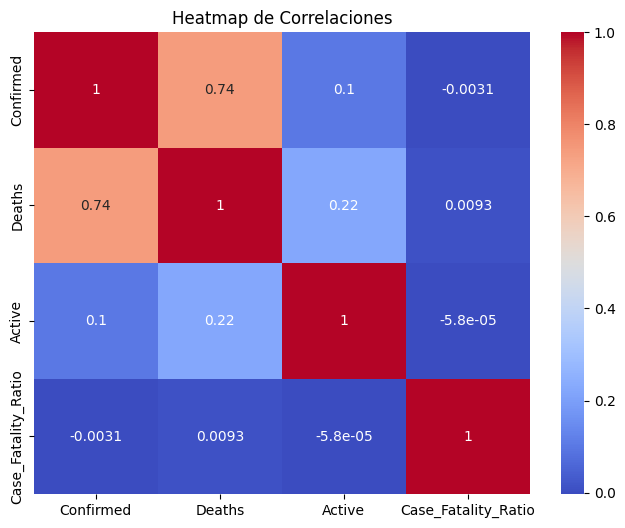

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

columnas_relevantes = ['Confirmed', 'Deaths', 'Active', 'Case_Fatality_Ratio']

correlationes = datos_covid_anuales[columnas_relevantes].dropna()

matriz_corr = correlationes.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm')
plt.title('Heatmap de Correlaciones')
plt.show()

Conversión terminada.


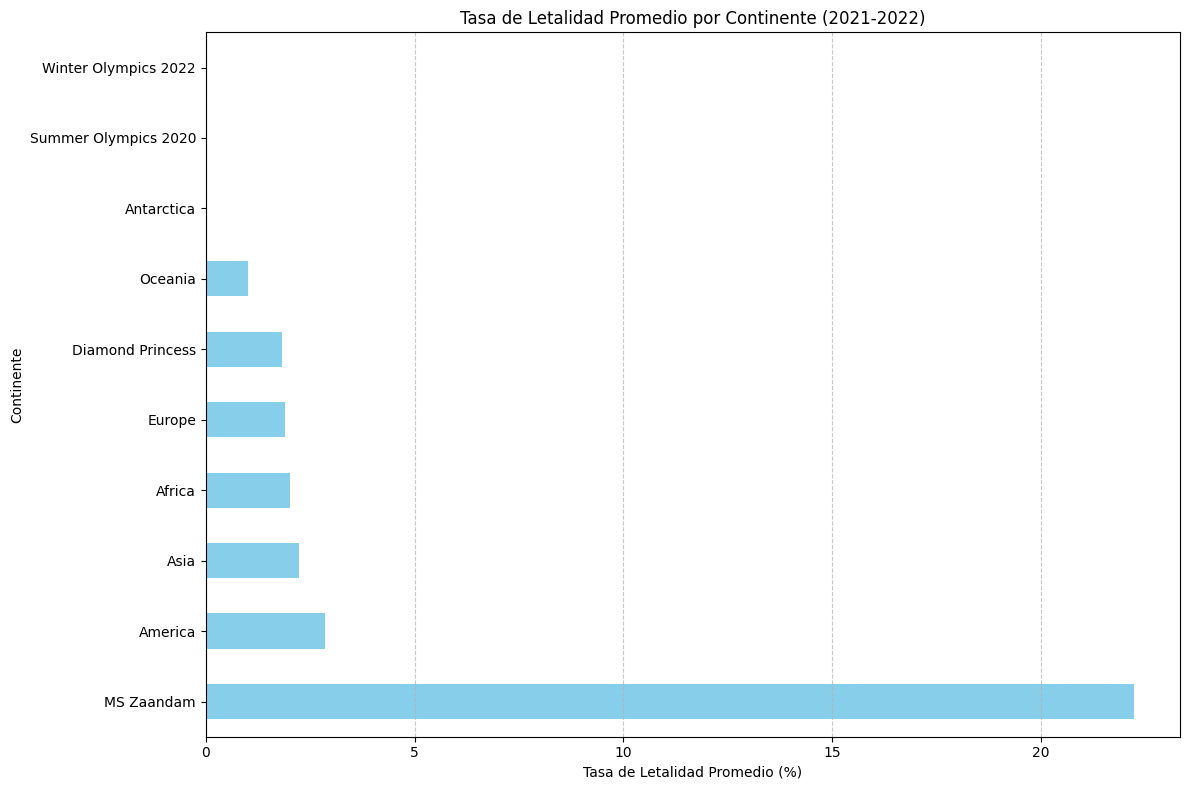

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import country_converter as coco
import warnings
import logging

# 1. CONFIGURACIÓN DE SILENCIO
warnings.filterwarnings('ignore')
logging.getLogger('country_converter').setLevel(logging.ERROR)

# --- Procesamiento Optimizado ---

# Estandarizar nombres
country_name_standardization = {
    "US": "United States",
    "Korea, North": "North Korea",
    "Korea, South": "South Korea",
    "Taiwan*": "Taiwan"
}
datos_covid_anuales['Country_Region'] = datos_covid_anuales['Country_Region'].replace(country_name_standardization)
datos_covid_anuales['Case_Fatality_Ratio'] = pd.to_numeric(datos_covid_anuales['Case_Fatality_Ratio'], errors='coerce')

# 2. EL TRUCO DE VELOCIDAD: Mapeo de Únicos
if 'Continent' not in datos_covid_anuales.columns or (datos_covid_anuales['Continent'] == 'Other').sum() > len(datos_covid_anuales) * 0.05:
    # Paso A: Obtener solo los nombres únicos de países 
    unique_countries = datos_covid_anuales['Country_Region'].unique()

    # Paso B: Convertir solo esa lista pequeña 
    continents_list = coco.convert(names=unique_countries, to='continent', not_found=None)

    # Paso C: Crear un diccionario {País: Continente}
    country_to_continent_map = dict(zip(unique_countries, continents_list))

    # Paso D: Aplicar el diccionario a la columna entera 
    datos_covid_anuales['Continent'] = datos_covid_anuales['Country_Region'].map(country_to_continent_map)

    # Rellenar nulos
    datos_covid_anuales['Continent'] = datos_covid_anuales['Continent'].fillna('Other')

    print("Conversión terminada.")

# 3. GRAFICAR
lethal_rate_by_continent = datos_covid_anuales.groupby('Continent')['Case_Fatality_Ratio'].mean().dropna().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
lethal_rate_by_continent.plot(kind='barh', color='skyblue')
plt.title('Tasa de Letalidad Promedio por Continente (2021-2022)')
plt.xlabel('Tasa de Letalidad Promedio (%)')
plt.ylabel('Continente')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [7]:
#5. Mapa o gráfico geográfico que muestre la incidencia por continente o país (opcional).

import plotly.express as px


covid_anuales.dropna(subset=['Last_Update'], inplace=True)

latest_data = covid_anuales.sort_values('Last_Update').drop_duplicates(subset=['Country_Region'], keep='last')

confirmed_cases_by_country = latest_data.groupby('Country_Region')['Confirmed'].sum().reset_index()

fig = px.choropleth(
    confirmed_cases_by_country,
    locations='Country_Region',
    locationmode='country names',
    color='Confirmed',
    hover_name='Country_Region',
    color_continuous_scale=px.colors.sequential.Plasma,
    title='Casos de covid confirmados por pais'
    )

fig.show()

In [8]:
# --- Al final de tu código de la Parte 3 ---

# Guardamos el archivo listo para que el Dashboard lo pueda leer
print("Guardando archivo para el Dashboard...")
covid_anuales.to_csv('covid_final_dashboard.csv', index=False)
print("¡Archivo 'covid_final_dashboard.csv' guardado con éxito!")

Guardando archivo para el Dashboard...
¡Archivo 'covid_final_dashboard.csv' guardado con éxito!


In [9]:
covid_anuales[["Active","Deaths","Recovered","Confirmed"]].sum()

Active         7489358731
Deaths         3718497454
Recovered     18292352139
Confirmed    263663275274
dtype: int64